# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [3]:
import numpy as np
import pandas as pd
import os,cv2
#from scipy.misc import imread, imresize
from cv2 import imread, resize
import datetime
import glob
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

## Reading the images

In [5]:
#Total trainable sequences
#video_path = 'D:/Assignment_RNN/Project_data/train/*'
video_path = '/home/datasets/Project_data/train/*'
print('Total Trainable videos:',len(glob.glob(video_path)))

Total Trainable videos: 663


In [6]:
#Different image shapes present in the video
vf_ratio = []
for vf in glob.glob(video_path):
    for img in glob.glob(vf+'/*'):
        vf_ratio.append(imread(img).shape)
        break
vf_ratio = set(vf_ratio)
print('Following video aspect ratio present in the dataset:',vf_ratio)

Following video aspect ratio present in the dataset: {(120, 160, 3), (360, 360, 3)}


In [7]:
def display_resized_image(inp_shape):
    dis = 0
    for folder in glob.glob(video_path):
        for img in glob.glob(folder+'/*'):
            #temp.append(imread(img).shape)
            if imread(img).shape == inp_shape:
               image = imread(img)
               plt.figure(figsize=(15,20))
               plt.subplot(1,3,1)
               plt.title(image.shape)
               image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
               plt.imshow(image)
               image = image[10:image.shape[0]-10,]
               plt.subplot(1,3,2)
               plt.title(image.shape)
               image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
               plt.imshow(image)
               image = resize(image,(160,120)) #(weidth x height)
               plt.subplot(1,3,3)
               plt.title(image.shape)
               image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
               plt.imshow(image)
               plt.tight_layout()
               dis+=1
            break
        if dis==1:
            break

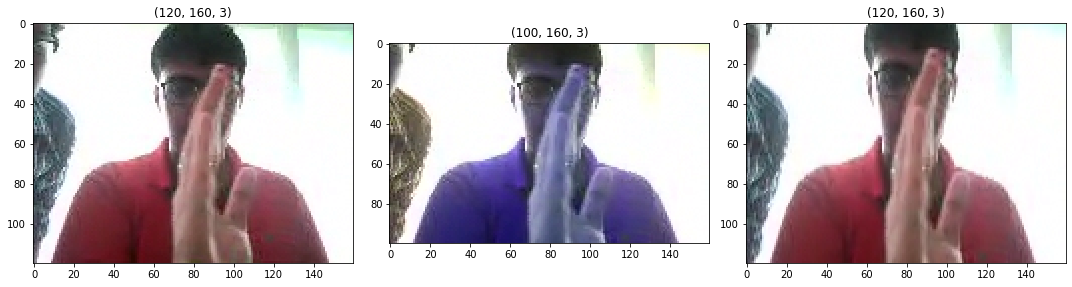

In [8]:
inp_shape = display_resized_image((120, 160, 3))

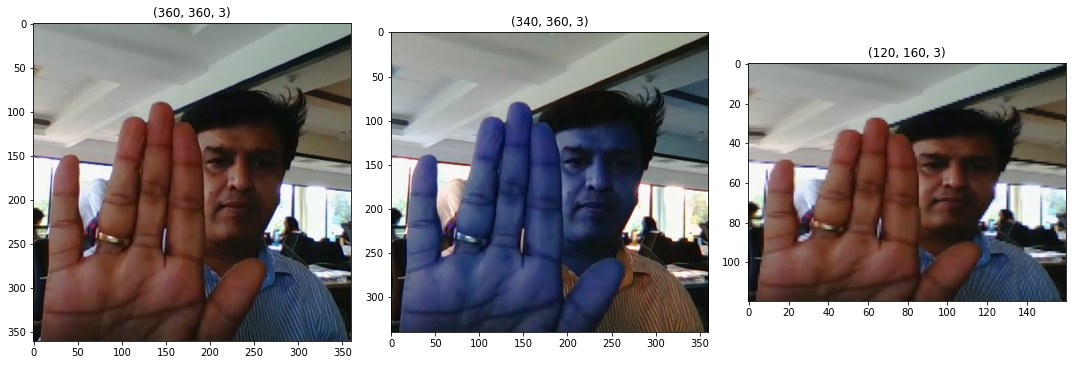

In [9]:
inp_shape = display_resized_image((360, 360, 3))

In [10]:
# image resolution has not been degraded with 80x100, so we will use 80 x 100 for processing.

## Checking the class balance:

In [11]:
train_details = pd.read_csv('/home/datasets/Project_data/train.csv', sep=';', names=['video folder','gesture','gclass'])

In [12]:
train_details.head()

,video folder,gesture,gclass
0,WIN_20180925_17_08_43_Pro_Left_Swipe_new,Left_Swipe_new,0
1,WIN_20180925_17_18_28_Pro_Left_Swipe_new,Left_Swipe_new,0
2,WIN_20180925_17_18_56_Pro_Left_Swipe_new,Left_Swipe_new,0
3,WIN_20180925_17_19_51_Pro_Left_Swipe_new,Left_Swipe_new,0
4,WIN_20180925_17_20_14_Pro_Left_Swipe_new,Left_Swipe_new,0


In [13]:
train_details.gesture.value_counts()

Right_Swipe_new                  103
Thumbs_Down_new                  100
Left_Swipe_new                    96
Stop_new                          93
Thumbs_Up_new                     87
Left Swipe_new_Left Swipe_new     40
Stop Gesture_new                  37
Thumbs Down_new                   37
Thumbs Up_new                     36
Right Swipe_new                   34
Name: gesture, dtype: int64

In [14]:
train_details.gesture = train_details.gesture.replace('Left Swipe_new_Left Swipe_new','Left_Swipe_new')
train_details.gesture = train_details.gesture.replace('Stop Gesture_new','Stop_new')
train_details.gesture = train_details.gesture.replace('Thumbs Down_new','Thumbs_Down_new')
train_details.gesture = train_details.gesture.replace('Thumbs Up_new','Thumbs_Up_new')
train_details.gesture = train_details.gesture.replace('Right Swipe_new','Right_Swipe_new')

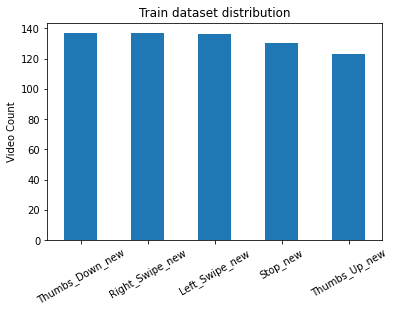

In [15]:
#The given dataset has 5 classes and is well balanced.
train_details.gesture.value_counts().plot.bar()
plt.xticks(rotation=30)
plt.ylabel('Video Count')
plt.title('Train dataset distribution')
plt.show()

In [16]:
#Total video count from CSV is matching with the given data.
train_details.gclass.count()

663

## Initializing variables

In [17]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
#batch_size = #experiment with the batch size
batch_size = 32
imagelnt = range(0,30,2)
#dim_y,dim_z = 80,100  #height x weight
dim_y,dim_z = 100,100

In [77]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

#set data augmentor
multiplier = 1   # This multiplier multiplies the same data set
num_train_sequences = len(train_doc)*multiplier
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
#num_epochs = # choose the number of epochs
num_epochs = 15
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [19]:
def norm_mimmax_rgb(channel):
    return (channel - np.min(channel))/(np.max(channel)-np.min(channel))

In [20]:
def generator(source_path, folder_list, batch_size, trainset=False, data_multiplier=1,data_agumentor=False ,display=False):
    print( '\nSource path = ', source_path, '; batch size =', batch_size)
    #img_idx = #create a list of image numbers you want to use for a particular video
    img_idx = imagelnt
    x = len(img_idx)
    y,z = dim_y,dim_z # heightxweight
    while True:
        #augments the training dataset by multiplying with user input. Default argument = 1
        if trainset:
            #t = np.concatenate([np.random.permutation(folder_list),np.random.permutation(folder_list)])
            t = np.random.permutation(np.concatenate([np.random.permutation(folder_list)]*data_multiplier))
        else:
            t = np.random.permutation(folder_list)
        if display:
            print('Training set dimension:',t.ndim)
            print('Training set shape',t.shape)

        if len(t)%batch_size == 0:
            num_batches = int(len(t)/batch_size)  # calculate the number of batches
        else:
            num_batches = (len(t)//batch_size)+1   # calculate the number of batches
        last_batch = len(t)%batch_size
        count = 0

        for index,batch in enumerate(range(num_batches)): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            count+=1
            for folder in range(batch_size): # iterate over the batch_size
                # to handle the left over batch
                if count==num_batches:
                    #print(folder)
                    if last_batch == folder:
                        break
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                if display:
                    plt.figure(figsize=(20,15))

                if trainset and data_agumentor:
                    add = np.random.randint(5) #Random data augmentation
                if trainset and data_agumentor and display:
                    if add ==1:
                        print('Added Gaussian Blur')
                    elif add ==2:
                        print('Added Gaussian noise')
                    elif add ==3:
                        print('Increased the brightness')
                    elif add==4:
                        print('Sharpened the image')
                    else:
                        print('No image transformation')
                
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if trainset:
                        #Cropping the top and bottom 10 pixels
                        image = image[10:image.shape[0]-10,]

                        #Applying Spatiol transformations. Part of images with add=0, are trained without augmentation
                        if data_agumentor:
                            #Adding Gaussian blur to the image
                            if add ==1:
                                image = cv2.GaussianBlur(image, (7,7),0) # kernel 7x7 added to blur the video frames
                                
                            ##Adding Gaussian noise to the image
                            if add ==2:
                                gaussian_noise = np.random.normal(0, 1, image.shape).astype(np.float32) # With SD 1, minor noise is added.
                                image = cv2.add(image,gaussian_noise)
                                    
                            #Adding contrast to the image
                            if add ==3:
                                image = cv2.convertScaleAbs(image, alpha=1.2, beta=0) # alpha 1.2 slightly increases the brightnes
                                    
                            # Sharpening the image
                            if add ==4:
                                sharpening_kernel = np.array([[0, -1, 0],[-1, 5,-1],[0, -1, 0]])
                                image = cv2.filter2D(image,-1, sharpening_kernel)    
                                                        
                    #Resizing the image 
                    image = resize(image,(z,y))  #z and y defined at the beggining of generator function
                    if display:
                        plt.subplot(5,(x//2)-2,idx+1)
                        plt.imshow(cv2.cvtColor(image.astype('uint8'),cv2.COLOR_BGR2RGB))
                        plt.axis('off')
                        plt.tight_layout()
          
                    #Normalizing the image
                    B,G,R = cv2.split(image)
                    batch_data[folder,idx,:,:,0] = norm_mimmax_rgb(R) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = norm_mimmax_rgb(G)
                    batch_data[folder,idx,:,:,2] = norm_mimmax_rgb(B)
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Generator validation


Source path =  /home/datasets/Project_data/train ; batch size = 1
Training set dimension: 1
Training set shape (1326,)


array([[0., 0., 0., 0., 1.]])

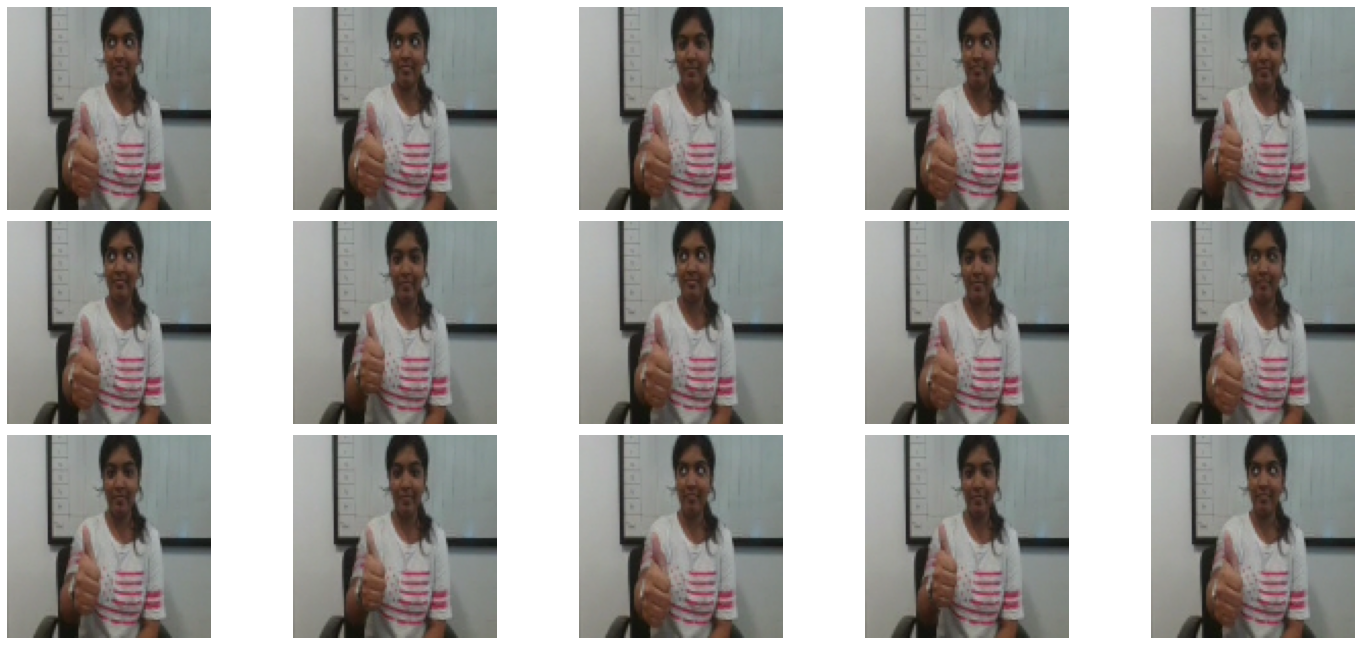

In [21]:
#Code to validate generator 
generatorval = generator(train_path, train_doc, 1, data_multiplier=2,data_agumentor=False,display=True, trainset=True)
next(generatorval)[1]
#Commented post validating

## Importing keras library

In [22]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, BatchNormalization, Activation, Conv2D, MaxPooling2D, Input, Dropout
from keras.layers import SimpleRNN, LSTM, GRU, TimeDistributed, Conv3D, MaxPooling3D
#from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from tensorflow.keras.optimizers import Adam

## Preparing the data for modeling

__Run this block of code on each model building__

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [78]:
train_generator = generator(train_path, train_doc, batch_size, data_multiplier=multiplier,data_agumentor=True,trainset=True)
val_generator = generator(val_path, val_doc, batch_size)

In [79]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print('No of videos(seqeunces):',num_train_sequences)
print('Batch Size:',batch_size)
print('Train Epoch-steps:',steps_per_epoch)
print('Validation Epock-steps:',validation_steps)

No of videos(seqeunces): 663
Batch Size: 32
Train Epoch-steps: 21
Validation Epock-steps: 4


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [80]:
model_name = 'model8_Conv2D_final' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.weights.h5'
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')


#LR = # write the REducelronplateaeu code here
ReduceLROnPlateau
LR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr = 0,
    verbose=1
)
callbacks_list = [checkpoint, LR]

In [81]:
input_image = (len(imagelnt), dim_y, dim_z,3)
input_image

(15, 100, 100, 3)

## Ablation Test

In [27]:
# batch_size = 13
# no of batches = 4
# Total data = 50
# Epochs = 3

In [46]:
train_generator_ablation = generator(train_path, train_doc[np.random.choice(len(train_doc), size=50, replace=False)], 
                                     13, trainset=True,data_multiplier=1,data_agumentor=True)

In [47]:
#Conv3D model
basemodel = Sequential()

basemodel.add(Input(shape=input_image))
basemodel.add(Conv3D(filters=32, kernel_size=(3,3,3), activation='relu'))
basemodel.add(MaxPooling3D(pool_size=(1, 2, 2)))

basemodel.add(Conv3D(filters=64, kernel_size=(3,3,3), activation='relu'))
basemodel.add(MaxPooling3D(pool_size=(1, 2, 2)))

#Flatten the output
basemodel.add(Flatten())

# Fully connected layers
basemodel.add(Dense(128, activation='relu'))
basemodel.add(Dense(5, activation='softmax')) 

optimiser = 'adam'
basemodel.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (basemodel.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 13, 98, 98, 32)    2624      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 13, 49, 49, 32)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 11, 47, 47, 64)    55360     
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 11, 23, 23, 64)   0         
 3D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 372416)            0         
                                                                 
 dense_4 (Dense)             (None, 128)              

In [48]:
basemodel.fit_generator(train_generator_ablation, steps_per_epoch=4, epochs=15, verbose=1, 
             class_weight=None,workers=1, initial_epoch=0)

/tmp/ipykernel_203/3376327798.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  basemodel.fit_generator(train_generator_ablation, steps_per_epoch=4, epochs=15, verbose=1,



Source path =  /home/datasets/Project_data/train ; batch size = 13
Epoch 1/15
4/4 [==============================] - 2s 585ms/step - loss: 18.4487 - categorical_accuracy: 0.2692
Epoch 2/15
4/4 [==============================] - 2s 431ms/step - loss: 1.9945 - categorical_accuracy: 0.2115
Epoch 3/15
4/4 [==============================] - 2s 433ms/step - loss: 1.4475 - categorical_accuracy: 0.3654
Epoch 4/15
4/4 [==============================] - 2s 478ms/step - loss: 1.2975 - categorical_accuracy: 0.3269
Epoch 5/15
4/4 [==============================] - 2s 449ms/step - loss: 0.8608 - categorical_accuracy: 0.8077
Epoch 6/15
4/4 [==============================] - 2s 520ms/step - loss: 0.4724 - categorical_accuracy: 0.7692
Epoch 7/15
4/4 [==============================] - 2s 466ms/step - loss: 0.2070 - categorical_accuracy: 0.9038
Epoch 8/15
4/4 [==============================] - 2s 537ms/step - loss: 0.1244 - categorical_accuracy: 0.9423
Epoch 9/15
4/4 [==============================] - 2

## Model 1: Conv3D
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [55]:
#write your model here

In [63]:
#Conv3D - Two experiments completed 1st with data set 663 and 2nd with 1326 , 3rd with dataset 663 data aug
model = Sequential()

model.add(Input(shape=input_image))
model.add(Conv3D(filters=32, kernel_size=(3,3,3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(filters=64, kernel_size=(3,3,3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

#Flatten the output
model.add(Flatten())

# Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax')) 

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [64]:
#optimiser = #write your optimizer
optimiser = 'Adam'
#optimiser = Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 13, 98, 98, 32)    2624      
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 13, 49, 49, 32)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 11, 47, 47, 64)    55360     
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 11, 23, 23, 64)   0         
 3D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 372416)            0         
                                                                 
 dense_8 (Dense)             (None, 128)              

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
          callbacks=callbacks_list, validation_data=val_generator, 
          validation_steps=validation_steps, class_weight=None, workers=2, initial_epoch=0)

In [65]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
          callbacks=callbacks_list, validation_data=val_generator, 
          validation_steps=validation_steps, class_weight=None,workers=1, initial_epoch=0)

/tmp/ipykernel_203/1244729856.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,



Source path =  /home/datasets/Project_data/train ; batch size = 16
Epoch 1/15
42/42 [==============================] - ETA: 0s - loss: 3.1124 - categorical_accuracy: 0.2083
Source path =  /home/datasets/Project_data/val ; batch size = 16

Epoch 00001: val_loss improved from inf to 1.43619, saving model to model1_conv3D_2024-09-0407_56_23.580038/model-00001-3.11245-0.20833-1.43619-0.19643.weights.h5
42/42 [==============================] - 24s 558ms/step - loss: 3.1124 - categorical_accuracy: 0.2083 - val_loss: 1.4362 - val_categorical_accuracy: 0.1964 - lr: 0.0010
Epoch 2/15
42/42 [==============================] - ETA: 0s - loss: 1.5878 - categorical_accuracy: 0.1875
Epoch 00002: val_loss improved from 1.43619 to 1.43570, saving model to model1_conv3D_2024-09-0407_56_23.580038/model-00002-1.58780-0.18750-1.43570-0.20536.weights.h5
42/42 [==============================] - 23s 559ms/step - loss: 1.5878 - categorical_accuracy: 0.1875 - val_loss: 1.4357 - val_categorical_accuracy: 0.2054

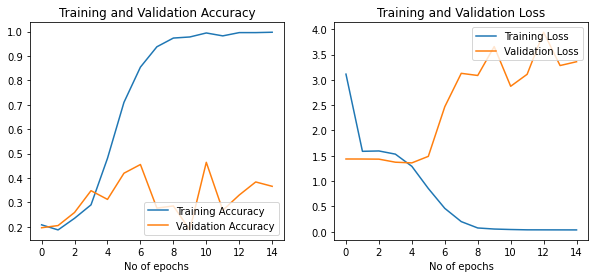

In [66]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('No of epochs')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('No of epochs')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Experiment1:

1. Model trained with batch 221, after 1st epoch, the model took more for start with second epoc. So, decided to reduce the batch size.

Experiment2:
1. Model trained with batch size 32 and dataset of 663 with SGD optimizer. Post reducing the batch size, model was proceed with further epochs. The training accuracy reached about 80.21% for 15 epochs. Lots of fluctuations observed with validation accuracy ranging from 35-42%.

Experiment3:
1. Model trained with batch size 32 with a dataset of 663 with `adam` optimizer. The training data quickly converged to 98.66% at 6th Epoch and remained stable. There are no fluctuations observed on validation data but the accuracy remained around 33 - 35%. This is clear sign of overfitting. The smoother output could be also attributed to batch size.

Experiment4:
1. Model trained with batch size 16 with a dataset of 663 with `adam` optimizer. The training data accuracy reached about 99.55% at 8th Epoch. The validation accuracy is fluctuating between 26% to 46%. The validation loss started increasing. So, reducing the batchsize deteriorated the model




## Model 2 Conv3D with Dropout

In [40]:
input_image

(15, 100, 100, 3)

In [81]:
#Conv3D Experiment4,
model2 = Sequential()

model2.add(Input(shape=input_image))
model2.add(Conv3D(filters=32, kernel_size=(3,3,3), activation='relu'))
model2.add(MaxPooling3D(pool_size=(1, 2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv3D(filters=64, kernel_size=(3,3,3), activation='relu'))
model2.add(MaxPooling3D(pool_size=(1, 2, 2)))
model2.add(Dropout(0.25))

#Flatten the output
model2.add(Flatten())

# Fully connected layers
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))

model2.add(Dense(5, activation='softmax')) 

#optimiser = #write your optimizer
#optimiser = optimizer.Adam(learning_rate=0.0001)
optimiser = 'adam'
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 13, 98, 98, 32)    2624      
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 13, 49, 49, 32)   0         
 g3D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 13, 49, 49, 32)    0         
                                                                 
 conv3d_13 (Conv3D)          (None, 11, 47, 47, 64)    55360     
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 11, 23, 23, 64)   0         
 g3D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 11, 23, 23, 64)   

In [82]:
history2 = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
          callbacks=callbacks_list, validation_data=val_generator, 
          validation_steps=validation_steps, workers=1, class_weight=None, initial_epoch=0)

/tmp/ipykernel_203/407649235.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,



Source path =  /home/datasets/Project_data/train ; batch size = 16
Epoch 1/15
42/42 [==============================] - ETA: 0s - loss: 3.9355 - categorical_accuracy: 0.2083
Source path =  /home/datasets/Project_data/val ; batch size = 16

Epoch 00001: val_loss improved from inf to 1.43641, saving model to model1_conv3D_2024-09-0408_50_48.649744/model-00001-3.93551-0.20833-1.43641-0.20536.weights.h5
42/42 [==============================] - 24s 576ms/step - loss: 3.9355 - categorical_accuracy: 0.2083 - val_loss: 1.4364 - val_categorical_accuracy: 0.2054 - lr: 0.0010
Epoch 2/15
42/42 [==============================] - ETA: 0s - loss: 1.5879 - categorical_accuracy: 0.2039
Epoch 00002: val_loss improved from 1.43641 to 1.43547, saving model to model1_conv3D_2024-09-0408_50_48.649744/model-00002-1.58790-0.20387-1.43547-0.22321.weights.h5
42/42 [==============================] - 23s 552ms/step - loss: 1.5879 - categorical_accuracy: 0.2039 - val_loss: 1.4355 - val_categorical_accuracy: 0.2232

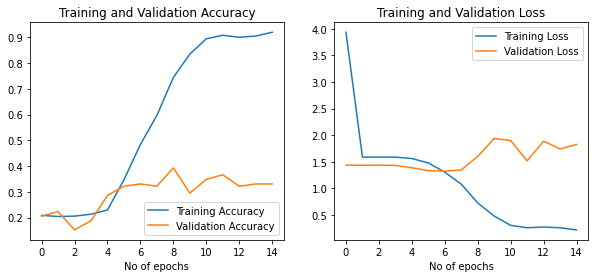

In [83]:
acc = history2.history['categorical_accuracy']
val_acc = history2.history['val_categorical_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('No of epochs')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('No of epochs')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Experiment 5:

1. Model2 built with Dropouts with batch size 32. The training accuracy reached 88.69% at 9th Epoch and stable. Validation accuracy is about 28-30% and is fluctuating. The validation loss increased initiatlly and dip, its about 1.57 to 1.49

Experiment 6:
1. Model2 built with Dropouts with batch size 16. The training accuracy increased to 91.96% but the validation accuracy stabilized at 33.04%. The validation loss around 1.82. The model is stil overfitting. Here with dropout, there is a marginal difference with batchsize 16 and batchsize 32.



## Model 3 - Conv3D with DP and BatchNormalization



In [89]:
#Conv3D
model3 = Sequential()

model3.add(Input(shape=input_image))
model3.add(Conv3D(filters=32, kernel_size=(3,3,3), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(1, 2, 2)))
model3.add(Dropout(0.2))

model3.add(Conv3D(filters=64, kernel_size=(3,3,3), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))
model3.add(Dropout(0.2))

#Flatten the output
model3.add(Flatten())

# Fully connected layers
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.5))

model3.add(Dense(5, activation='softmax')) 

#optimiser = #write your optimizer
optimiser = 'adam'
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_14 (Conv3D)          (None, 13, 98, 98, 32)    2624      
                                                                 
 batch_normalization (BatchN  (None, 13, 98, 98, 32)   128       
 ormalization)                                                   
                                                                 
 max_pooling3d_14 (MaxPoolin  (None, 13, 49, 49, 32)   0         
 g3D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 13, 49, 49, 32)    0         
                                                                 
 conv3d_15 (Conv3D)          (None, 11, 47, 47, 64)    55360     
                                                                 
 batch_normalization_1 (Batc  (None, 11, 47, 47, 64)  

In [90]:
history3 = model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
          callbacks=callbacks_list, validation_data=val_generator, 
          validation_steps=validation_steps, class_weight=None, initial_epoch=0)


Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 36.5102 - categorical_accuracy: 0.2768
Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 3.54988, saving model to model1_conv3D_2024-09-0409_22_50.743400/model-00001-36.51016-0.27679-3.54988-0.18750.weights.h5
21/21 [==============================] - 33s 2s/step - loss: 36.5102 - categorical_accuracy: 0.2768 - val_loss: 3.5499 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 7.5639 - categorical_accuracy: 0.3199
Epoch 00002: val_loss did not improve from 3.54988
21/21 [==============================] - 38s 2s/step - loss: 7.5639 - categorical_accuracy: 0.3199 - val_loss: 7.2486 - val_categorical_accuracy: 0.1797 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 4.2066 - categorical_accuracy: 0.2902

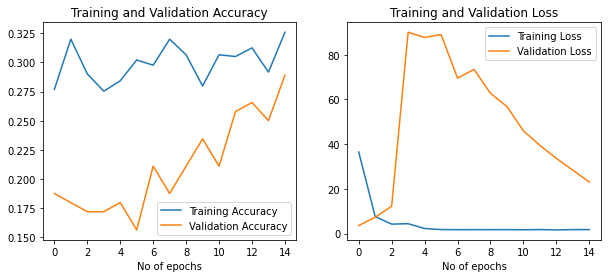

In [91]:
acc = history3.history['categorical_accuracy']
val_acc = history3.history['val_categorical_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('No of epochs')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('No of epochs')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Experiment 7:

1. BatchNormalization is added for the Model. The results shows lot of fluctuations in accuracy of training data from 27-32%. The model didn't converge with 15 Epochs and there seems to be no much improvement. The loss function for training data is stable and about 1.73 and validation loss is decreasing 23.614. As the convergency time is too high, not going to experiment much with this model architecture.  

## Model 4 - Conv2D with stack same filters back to back

In [98]:
#Conv3D
model4 = Sequential()

model4.add(Input(shape=input_image))
model4.add(Conv3D(filters=32, kernel_size=(3,3,3), activation='relu'))
model4.add(Conv3D(filters=32, kernel_size=(3,3,3), activation='relu'))
model4.add(MaxPooling3D(pool_size=(1, 2, 2)))
model4.add(Dropout(0.2))

model4.add(Conv3D(filters=64, kernel_size=(3,3,3), activation='relu'))
model4.add(Conv3D(filters=64, kernel_size=(3,3,3), activation='relu'))
model4.add(MaxPooling3D(pool_size=(1, 2, 2)))
model4.add(Dropout(0.2))

#Flatten the output
model4.add(Flatten())

# Fully connected layers
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.5))

model4.add(Dense(5, activation='softmax')) 

#optimiser = #write your optimizer
optimiser = 'adam'
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 13, 98, 98, 32)    2624      
                                                                 
 conv3d_17 (Conv3D)          (None, 11, 96, 96, 32)    27680     
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 11, 48, 48, 32)   0         
 g3D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 11, 48, 48, 32)    0         
                                                                 
 conv3d_18 (Conv3D)          (None, 9, 46, 46, 64)     55360     
                                                                 
 conv3d_19 (Conv3D)          (None, 7, 44, 44, 64)     110656    
                                                      

In [99]:
history4 = model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
          callbacks=callbacks_list, validation_data=val_generator, 
          validation_steps=validation_steps, workers=1, class_weight=None, initial_epoch=0)

/tmp/ipykernel_203/337018528.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history4 = model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,



Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 2.2225 - categorical_accuracy: 0.1756
Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.25725, saving model to model1_conv3D_2024-09-0409_34_15.854161/model-00001-2.22251-0.17560-1.25725-0.16406.weights.h5
21/21 [==============================] - 30s 1s/step - loss: 2.2225 - categorical_accuracy: 0.1756 - val_loss: 1.2572 - val_categorical_accuracy: 0.1641 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 1.5880 - categorical_accuracy: 0.2009
Epoch 00002: val_loss did not improve from 1.25725
21/21 [==============================] - 24s 1s/step - loss: 1.5880 - categorical_accuracy: 0.2009 - val_loss: 1.2573 - val_categorical_accuracy: 0.1406 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 1.5878 - categorical_accuracy: 0.1994
Ep

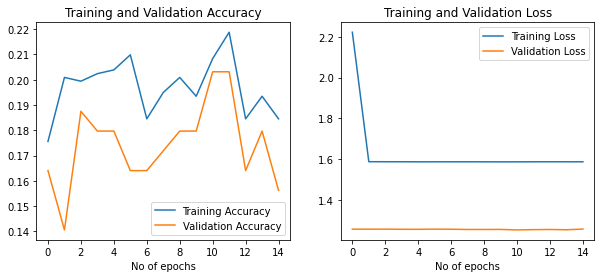

In [100]:
acc = history4.history['categorical_accuracy']
val_acc = history4.history['val_categorical_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('No of epochs')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('No of epochs')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Experiment8:

The model4 is trained by stacking Conv3D 32 and 64 back to back to check the performance. Lot of fluctuation observed with training and validation accuracy. The training and validation loss is constant. Discarding this model

## Model 5 Conv3D Droput with increased frames

In [105]:
input_image

(15, 100, 100, 3)

In [118]:
#Conv3D Experiment 5 
#Experiment 8 with lr 0.0001
model5 = Sequential()

model5.add(Input(shape=input_image))
model5.add(Conv3D(filters=32, kernel_size=(3,3,3), activation='relu'))
model5.add(MaxPooling3D(pool_size=(1, 2, 2)))
model5.add(Dropout(0.2))

model5.add(Conv3D(filters=64, kernel_size=(3,3,3), activation='relu'))
model5.add(MaxPooling3D(pool_size=(1, 2, 2)))
model5.add(Dropout(0.2))

model5.add(Conv3D(filters=128, kernel_size=(3,3,3), activation='relu'))
model5.add(MaxPooling3D(pool_size=(2, 2, 2)))
model5.add(Dropout(0.2))

#Flatten the output
model5.add(Flatten())

# Fully connected layers
model5.add(Dense(128, activation='relu'))
model5.add(Dense(64, activation='relu'))
model5.add(Dropout(0.5))

model5.add(Dense(5, activation='softmax')) 

#optimiser = #write your optimizer
optimiser = 'adam'
#optimiser = Adam(learning_rate=0.0001)
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_38 (Conv3D)          (None, 13, 98, 98, 32)    2624      
                                                                 
 max_pooling3d_36 (MaxPoolin  (None, 13, 49, 49, 32)   0         
 g3D)                                                            
                                                                 
 dropout_36 (Dropout)        (None, 13, 49, 49, 32)    0         
                                                                 
 conv3d_39 (Conv3D)          (None, 11, 47, 47, 64)    55360     
                                                                 
 max_pooling3d_37 (MaxPoolin  (None, 11, 23, 23, 64)   0         
 g3D)                                                            
                                                                 
 dropout_37 (Dropout)        (None, 11, 23, 23, 64)  

In [119]:
history5 = model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
          callbacks=callbacks_list, validation_data=val_generator, 
          validation_steps=validation_steps, workers=1, class_weight=None, initial_epoch=0)

/tmp/ipykernel_203/1531481082.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history5 = model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,



Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/15
42/42 [==============================] - ETA: 0s - loss: 1.6514 - categorical_accuracy: 0.1897
Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.25045, saving model to model1_conv3D_2024-09-0410_16_31.957326/model-00001-1.65136-0.18973-1.25045-0.20312.weights.h5
42/42 [==============================] - 43s 1s/step - loss: 1.6514 - categorical_accuracy: 0.1897 - val_loss: 1.2504 - val_categorical_accuracy: 0.2031 - lr: 0.0010
Epoch 2/15
42/42 [==============================] - ETA: 0s - loss: 1.5204 - categorical_accuracy: 0.2909
Epoch 00002: val_loss improved from 1.25045 to 1.10775, saving model to model1_conv3D_2024-09-0410_16_31.957326/model-00002-1.52043-0.29092-1.10775-0.34375.weights.h5
42/42 [==============================] - 41s 1s/step - loss: 1.5204 - categorical_accuracy: 0.2909 - val_loss: 1.1078 - val_categorical_accuracy: 0.3438 - lr:

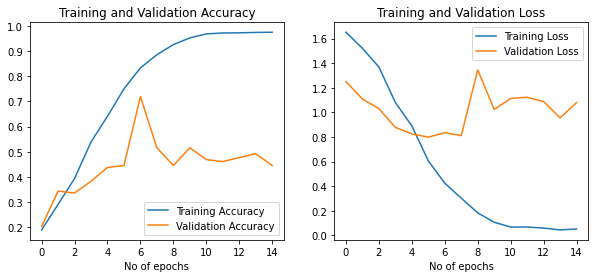

In [120]:
acc = history5.history['categorical_accuracy']
val_acc = history5.history['val_categorical_accuracy']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('No of epochs')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('No of epochs')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Experiment 9:

1. Model5 is stacked with additional filter 128 layer. The model is trained with 32 batch size. The training accuracy of the model is 38.39% and validation accuracy is 45.31%. The model is underfitting with 15 Epochs. The loss is steadily decreasing.

Experiment 10:

1. Model5 is trained with dataset 1326 with 32 batch size.



## Model 6 with FC 64 and MaxPool 2,2,2

In [149]:
#Conv3D Experiment 6 with more no of images and default adam lr 0.0001 - FC reduced to 64
model6 = Sequential()

model6.add(Input(shape=input_image))
model6.add(Conv3D(filters=32, kernel_size=(3,3,3), activation='relu'))
model6.add(MaxPooling3D(pool_size=(2, 2, 2)))
model6.add(Dropout(0.25))

model6.add(Conv3D(filters=64, kernel_size=(5,5,5), activation='relu'))
model6.add(MaxPooling3D(pool_size=(2, 2, 2)))
model6.add(Dropout(0.25))

#model5.add(Conv3D(filters=128, kernel_size=(3,3,3), activation='relu'))
#model5.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model5.add(Dropout(0.2))

#Flatten the output
model6.add(Flatten())

# Fully connected layers
model6.add(Dense(64, activation='relu'))
model6.add(Dropout(0.5))

model6.add(Dense(5, activation='softmax')) 

#optimiser = #write your optimizer
#optimiser = 'adam'
optimiser = Adam(learning_rate=0.0001)
model6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model6.summary())

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_49 (Conv3D)          (None, 13, 98, 98, 32)    2624      
                                                                 
 max_pooling3d_47 (MaxPoolin  (None, 6, 49, 49, 32)    0         
 g3D)                                                            
                                                                 
 dropout_52 (Dropout)        (None, 6, 49, 49, 32)     0         
                                                                 
 conv3d_50 (Conv3D)          (None, 2, 45, 45, 64)     256064    
                                                                 
 max_pooling3d_48 (MaxPoolin  (None, 1, 22, 22, 64)    0         
 g3D)                                                            
                                                                 
 dropout_53 (Dropout)        (None, 1, 22, 22, 64)   

In [150]:
history6 = model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
          callbacks=callbacks_list, validation_data=val_generator, 
          validation_steps=validation_steps, class_weight=None,workers=1, initial_epoch=0)

/tmp/ipykernel_203/2100501695.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history6 = model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,



Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/25
42/42 [==============================] - ETA: 0s - loss: 1.5848 - categorical_accuracy: 0.2433
Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.20703, saving model to model1_conv3D_2024-09-0411_31_05.406700/model-00001-1.58483-0.24330-1.20703-0.24219.weights.h5
42/42 [==============================] - 44s 1s/step - loss: 1.5848 - categorical_accuracy: 0.2433 - val_loss: 1.2070 - val_categorical_accuracy: 0.2422 - lr: 1.0000e-04
Epoch 2/25
42/42 [==============================] - ETA: 0s - loss: 1.4589 - categorical_accuracy: 0.3192
Epoch 00002: val_loss improved from 1.20703 to 1.09783, saving model to model1_conv3D_2024-09-0411_31_05.406700/model-00002-1.45885-0.31920-1.09783-0.44531.weights.h5
42/42 [==============================] - 44s 1s/step - loss: 1.4589 - categorical_accuracy: 0.3192 - val_loss: 1.0978 - val_categorical_accuracy: 0.4453 -

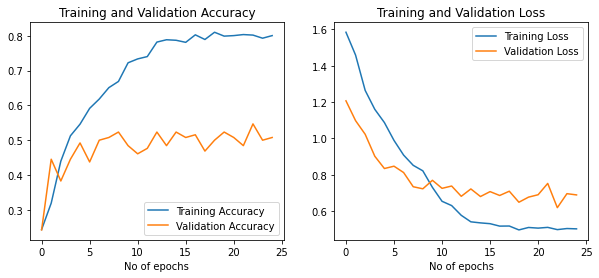

In [151]:
acc = history6.history['categorical_accuracy']
val_acc = history6.history['val_categorical_accuracy']

loss = history6.history['loss']
val_loss = history6.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('No of epochs')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('No of epochs')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Experiment 11:

Model 6 with batch size 32 and dataset 663, the training data reached an accuracy of 73.21% for 12th Epochs. The validation accuracy is fluctuating between 38 to 67%. The training and validation loss has steadily decreased. 

Experiment 12:

Changing the LR to 0.0001 to handle the fluctuations observed in Validation accuracy with 25 epochs. The dataset and batch size is 663, 32 respectively. The training accuracy is 75.30%. Validation accuracy is about 46-54%. The huge fluctuation observed in Experiment 11 is handled post decreasing the LR to 0.0001. 

Experiment13:

With same Model 6, fed 1326 data with 32 batch size with LR 0.0001. The training accuracy increased to 80% but the validation accuracy remained arround 50%. The loss has steadily decreased.

## Model 7 Conv2D + LSTM

In [158]:
# Conv2D + LSTM

model7 = Sequential()
model7.add(Input(shape=input_image))
model7.add(TimeDistributed(Conv2D(filters=32, kernel_size=(3, 3), activation='relu')))
model7.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model7.add(TimeDistributed(Conv2D(filters=64, kernel_size=(3,3), activation='relu')))
model7.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

#Flatten the output
model7.add(TimeDistributed(Flatten()))

#LSTM layer
model7.add(LSTM(64, return_sequences=False))

# Fully connected layers for classification
model7.add(Dense(128, activation='relu'))
model7.add(Dense(5, activation='softmax')) 

#optimiser = #write your optimizer
optimiser = 'adam'
model7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model7.summary())

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 98, 98, 32)   896       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 49, 49, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 47, 47, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 23, 23, 64)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 33856)      

In [159]:
history7 = model7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
          callbacks=callbacks_list, validation_data=val_generator, 
          validation_steps=validation_steps, workers=1 ,class_weight=None, initial_epoch=0)

/tmp/ipykernel_203/4288439138.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history7 = model7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,



Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 1.5963 - categorical_accuracy: 0.1949
Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.24208, saving model to model1_conv3D_2024-09-0412_06_11.091822/model-00001-1.59629-0.19494-1.24208-0.24219.weights.h5
21/21 [==============================] - 27s 1s/step - loss: 1.5963 - categorical_accuracy: 0.1949 - val_loss: 1.2421 - val_categorical_accuracy: 0.2422 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 1.5419 - categorical_accuracy: 0.3199
Epoch 00002: val_loss improved from 1.24208 to 1.14850, saving model to model1_conv3D_2024-09-0412_06_11.091822/model-00002-1.54185-0.31994-1.14850-0.27344.weights.h5
21/21 [==============================] - 23s 1s/step - loss: 1.5419 - categorical_accuracy: 0.3199 - val_loss: 1.1485 - val_categorical_accuracy: 0.2734 - lr:

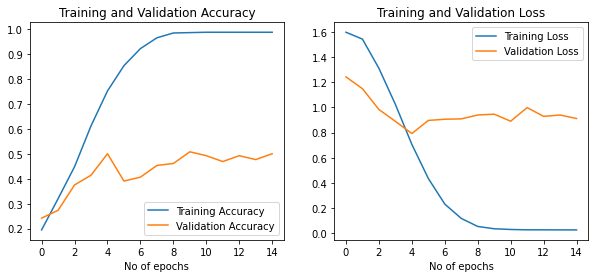

In [160]:
acc = history7.history['categorical_accuracy']
val_acc = history7.history['val_categorical_accuracy']

loss = history7.history['loss']
val_loss = history7.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('No of epochs')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('No of epochs')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Experiment 14:

Model 7 is fed with dataset 663 and with a batch size of 32.The training accuracy reached 98.66% at 8th epoch and it remains stable. The validation accuracy is about 50%. The validation loss is around 0.91

## Model 8 Conv2D + LSTM with dropout

In [82]:
# Conv2D + LSTM with dropout

model8 = Sequential()
model8.add(Input(shape=input_image))
model8.add(TimeDistributed(Conv2D(filters=32, kernel_size=(3, 3), activation='relu')))
model8.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model8.add(TimeDistributed(Dropout(0.25)))

model8.add(TimeDistributed(Conv2D(filters=64, kernel_size=(3,3), activation='relu')))
model8.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model8.add(TimeDistributed(Dropout(0.25)))

#Flatten the output
model8.add(TimeDistributed(Flatten()))

#LSTM layer
model8.add(LSTM(64, return_sequences=False))

# Fully connected layers for classification
model8.add(Dense(128, activation='relu'))
model8.add(Dense(5, activation='softmax')) 

#optimiser = #write your optimizer
optimiser = 'adam'
model8.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model8.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_59 (TimeDi  (None, 15, 98, 98, 32)   896       
 stributed)                                                      
                                                                 
 time_distributed_60 (TimeDi  (None, 15, 49, 49, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_61 (TimeDi  (None, 15, 49, 49, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_62 (TimeDi  (None, 15, 47, 47, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_63 (TimeDi  (None, 15, 23, 23, 64)  

In [83]:
history8 = model8.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
          callbacks=callbacks_list, validation_data=val_generator, 
          validation_steps=validation_steps,workers=1, class_weight=None, initial_epoch=0)

/tmp/ipykernel_402/1920327985.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history8 = model8.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,



Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 1.5928 - categorical_accuracy: 0.2336
Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model8_Conv2D_final_2024-09-0414_06_16.689432/model-00001-1.59281-0.23363-1.23024-0.18750.keras
21/21 [==============================] - 42s 2s/step - loss: 1.5928 - categorical_accuracy: 0.2336 - val_loss: 1.2302 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 1.5396 - categorical_accuracy: 0.3244
Epoch 00002: saving model to model8_Conv2D_final_2024-09-0414_06_16.689432/model-00002-1.53961-0.32440-1.19700-0.25781.keras
21/21 [==============================] - 38s 2s/step - loss: 1.5396 - categorical_accuracy: 0.3244 - val_loss: 1.1970 - val_categorical_accuracy: 0.2578 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 1.46

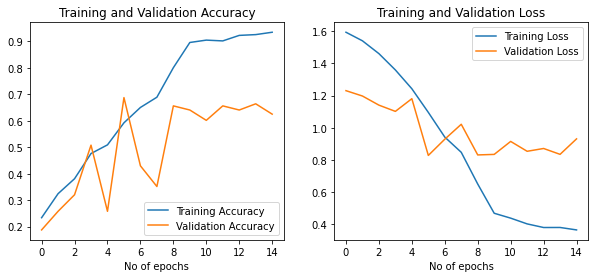

In [84]:
acc = history8.history['categorical_accuracy']
val_acc = history8.history['val_categorical_accuracy']

loss = history8.history['loss']
val_loss = history8.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('No of epochs')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('No of epochs')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Experiment 15:

Model 8 is fed with dataset 663 and with a batch size of 32.The training accuracy reached 99.55% at 8th epoch and it remains stable. The validation accuracy is about 64 to 67%. The validation loss is around 0.9981.

Experiment 16:

Compared other models, Model 8 seems to performed well though its overfitting. So, training the same model with more dataset and data augmentation. The training accuracy has reached to 97.84% and the validation accuracy is about 33.59%. This is again overfitting.So, discarding this model.

Experiment 17:

Model 8 is trained with 663 dataset with batch size of 32 in additon, data augmentation is enabled. The training accuracy has reached about 93.45% and validation accuracy has reached upto 66.41%. The validation loss is around 0.8350


## Model9

In [27]:
# Conv2D + LSTM

model9 = Sequential()
model9.add(Input(shape=input_image))
model9.add(TimeDistributed(Conv2D(filters=32, kernel_size=(3, 3), activation='relu')))
model9.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model9.add(TimeDistributed(Dropout(0.25)))

model9.add(TimeDistributed(Conv2D(filters=64, kernel_size=(3,3), activation='relu')))
model9.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model9.add(TimeDistributed(Dropout(0.25)))

#Flatten the output
model9.add(TimeDistributed(Flatten()))

#LSTM layer
model9.add(LSTM(32, return_sequences=False))
model9.add(Dropout(0.2))

# Fully connected layers for classification
model9.add(Dense(64, activation='relu'))
model9.add(Dropout(0.2))

model9.add(Dense(5, activation='softmax')) 

#optimiser = #write your optimizer
optimiser = 'adam'
model9.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model9.summary())

2024-09-04 13:04:26.566774: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-09-04 13:04:26.566854: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3d:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 98, 98, 32)   896       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 49, 49, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 49, 49, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 47, 47, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 23, 23, 64)   0

In [28]:
history9 = model9.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
          callbacks=callbacks_list, validation_data=val_generator, 
          validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_402/1450895216.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history9 = model9.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,



Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/15


2024-09-04 13:05:11.749085: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.6421 - categorical_accuracy: 0.2039
Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.24906, saving model to model1_conv3D_2024-09-0413_03_40.501948/model-00001-1.64205-0.20387-1.24906-0.16406.weights.h5
21/21 [==============================] - 28s 1s/step - loss: 1.6421 - categorical_accuracy: 0.2039 - val_loss: 1.2491 - val_categorical_accuracy: 0.1641 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 1.6070 - categorical_accuracy: 0.2217
Epoch 00002: val_loss improved from 1.24906 to 1.23825, saving model to model1_conv3D_2024-09-0413_03_40.501948/model-00002-1.60696-0.22173-1.23825-0.17969.weights.h5
21/21 [==============================] - 24s 1s/step - loss: 1.6070 - categorical_accuracy: 0.2217 - val_loss: 1.2383 - val_categorical_accuracy: 0.1797 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 1.5

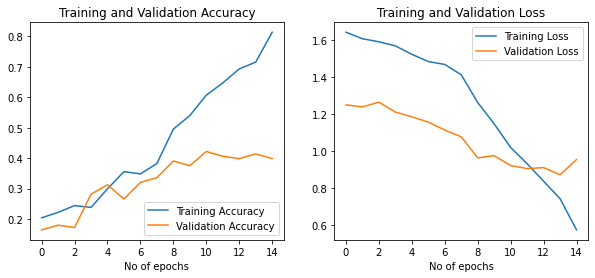

In [29]:
acc = history9.history['categorical_accuracy']
val_acc = history9.history['val_categorical_accuracy']

loss = history9.history['loss']
val_loss = history9.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('No of epochs')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('No of epochs')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Experiment 17:

Model 9 trained with 663 dataset with 32 batch size. The training data reached an accuracy of 81.40% and validation set accuracy is around 39-40% with 15 Epochs. The model is overfitting. 

## Model 10 Conv2D + GRU

In [37]:
# Conv2D + GRU

model10 = Sequential()
model10.add(Input(shape=input_image))
model10.add(TimeDistributed(Conv2D(filters=32, kernel_size=(3, 3), activation='relu')))
model10.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model10.add(TimeDistributed(Conv2D(filters=64, kernel_size=(3,3), activation='relu')))
model10.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

#Flatten the output
model10.add(TimeDistributed(Flatten()))

#LSTM layer
model10.add(GRU(32, return_sequences=False))
model10.add(Dropout(0.2))

# Fully connected layers for classification
model10.add(Dense(64, activation='relu'))
model10.add(Dropout(0.2))

model10.add(Dense(5, activation='softmax')) 

#optimiser = #write your optimizer
optimiser = 'adam'
model10.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model10.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 15, 98, 98, 32)   896       
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 15, 49, 49, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 15, 47, 47, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 15, 23, 23, 64)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 15, 33856)       

In [38]:
history10 = model10.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
          callbacks=callbacks_list, validation_data=val_generator, 
          validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_402/3212549020.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history10 = model10.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,



Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 1.6542 - categorical_accuracy: 0.2068
Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.25117, saving model to model1_conv3D_2024-09-0413_03_40.501948/model-00001-1.65415-0.20685-1.25117-0.17969.weights.h5
21/21 [==============================] - 27s 1s/step - loss: 1.6542 - categorical_accuracy: 0.2068 - val_loss: 1.2512 - val_categorical_accuracy: 0.1797 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 1.6108 - categorical_accuracy: 0.2262
Epoch 00002: val_loss improved from 1.25117 to 1.24700, saving model to model1_conv3D_2024-09-0413_03_40.501948/model-00002-1.61084-0.22619-1.24700-0.21094.weights.h5
21/21 [==============================] - 24s 1s/step - loss: 1.6108 - categorical_accuracy: 0.2262 - val_loss: 1.2470 - val_categorical_accuracy: 0.2109 - lr:

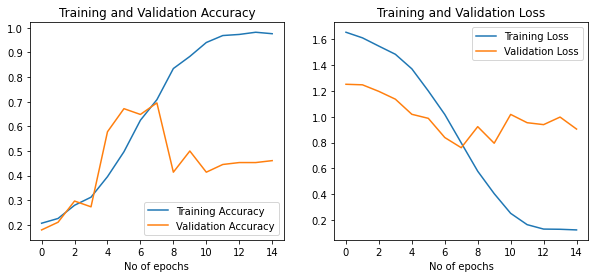

In [39]:
acc = history10.history['categorical_accuracy']
val_acc = history10.history['val_categorical_accuracy']

loss = history10.history['loss']
val_loss = history10.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('No of epochs')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('No of epochs')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Experiment 18:

The model10 is built with GRU. The model is trained with 663 dataset with 32 batch size. The training data reached an accuracy of 97.62% and validation set accuracy is around 46% with 15 Epochs. The model is overfitting. 

# Conclusion:

__Model 8 is trained with 663 dataset with batch size of 32 in additon, data augmentation is enabled. The training accuracy has reached about 93.45% and validation accuracy has reached upto 66.41%. The validation loss is around 0.8350__